# Simple Linear Regression

Import necessary modules:

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
import matplotlib as mpl
import pymc as pm

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

Load bodyfat data:

In [3]:
data = pd.read_csv("bodyfat.csv")
data.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
0,1.0708,12.3,23,70.0,172.1,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.6
1,1.0853,6.1,22,78.6,183.5,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.3
2,1.0414,25.3,22,69.9,168.3,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.7
3,1.0751,10.4,26,83.8,183.5,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.9
4,1.0340,28.7,24,83.6,181.0,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.5


Remove outliers:

In [4]:
data_simple = data[data.BMI<35]

## With PyMC

In [5]:
x = data_simple.BMI
y_obs = data_simple.BodyFat

with pm.Model() as linreg_model:
    # priors
    beta0 = pm.Normal('beta0', mu=data_simple.BodyFat.mean(), sigma=10 )
    beta1 = pm.Normal('beta1', mu=0, sigma=10 )
    sigma = pm.Exponential('sigma', lam=1/10 )

    # likelihood
    y = pm.Normal('y', mu=beta0+beta1*x, sigma=sigma, observed=y_obs )

    # simulate posterior
    trace = pm.sample( 2000 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


In [6]:
pm.summary( trace )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-24.745,2.754,-29.897,-19.577,0.056,0.042,2401.0,2815.0,1.0
beta1,1.733,0.109,1.534,1.942,0.002,0.002,2393.0,2800.0,1.0
sigma,5.552,0.262,5.065,6.039,0.005,0.004,3281.0,3255.0,1.0


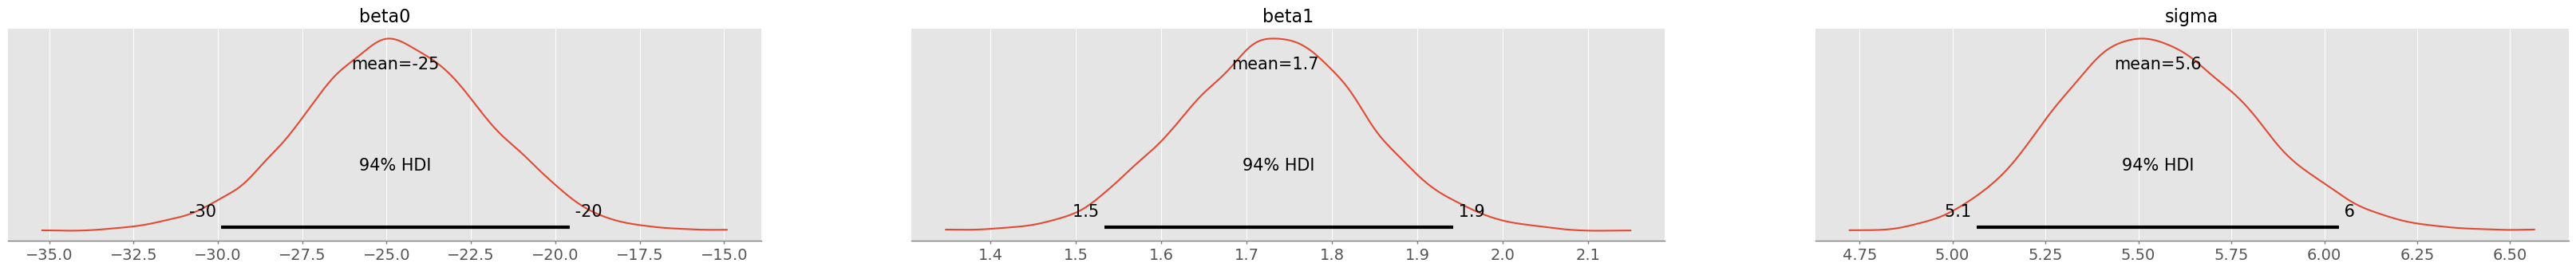

In [7]:
pm.plot_posterior( trace );

Plot a few sample posterior lines:

In [8]:
def plot_lines( trace, x, y, n_lines=100 ):
    # stack betas
    beta = np.hstack( [trace.posterior.beta0.values.reshape(-1,1), trace.posterior.beta1.values.reshape(-1,1)] )

    # compute mean values
    mean_beta = beta.mean(axis=0)
    
    # subsample
    inds = np.random.choice( np.arange(beta.shape[0]), n_lines )
    beta = beta[inds,:]

    # plot
    xrange = np.linspace( 0.9*np.min(x), 1.1*np.max(x), 1000 )
    plt.scatter( x, y )
    for i in range( beta.shape[0] ):
        plt.plot( xrange, beta[i,0] + beta[i,1] * xrange, c="blue", alpha=0.03 )

    # mean line
    mean_line = mean_beta[0] + mean_beta[1] * xrange
    plt.plot( xrange, mean_line, c="black" )

Text(0, 0.5, 'BodyFat')

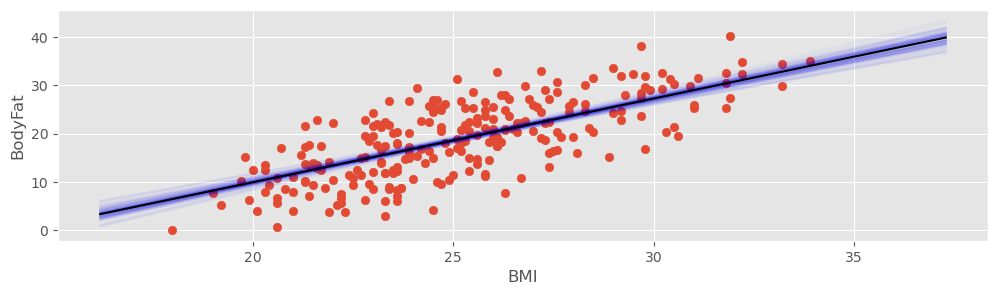

In [9]:
plot_lines( trace, x, y_obs, n_lines=100 )
plt.xlabel("BMI")
plt.ylabel("BodyFat")

### Simulate from prior only

In [10]:
with pm.Model() as linreg_prior_model:
    # priors
    beta0 = pm.Normal('beta0', mu=data_simple.BodyFat.mean(), sigma=10 )
    beta1 = pm.Normal('beta1', mu=0, sigma=10 )
    sigma = pm.Exponential('sigma', lam=1/10 )

    # likelihood
    # y = pm.Normal('y', mu=beta0+beta1*x, sigma=sigma, observed=y_obs )

    # simulate prior
    trace_prior = pm.sample( 2000 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [11]:
pm.summary( trace_prior )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,18.944,10.033,0.631,38.230,0.111,0.112,8138.0,5802.0,1.0
beta1,-0.086,10.150,-18.855,19.151,0.121,0.121,6989.0,5377.0,1.0
sigma,9.833,9.708,0.000,27.726,0.115,0.165,4658.0,2930.0,1.0


Draw lines:

Text(0, 0.5, 'BodyFat')

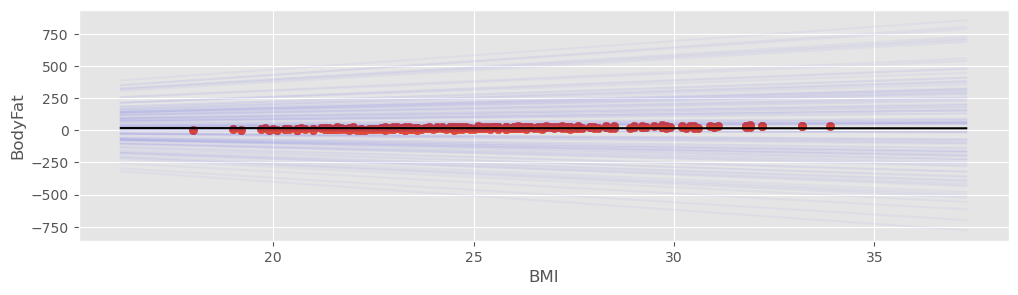

In [12]:
plot_lines( trace_prior, x, y_obs, n_lines=100 )
plt.xlabel("BMI")
plt.ylabel("BodyFat")

### Posterior Predictive HDIs

In [13]:
with linreg_model:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [y]


Output()

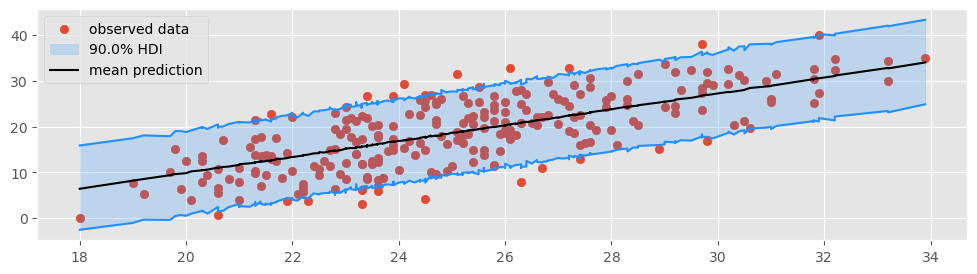

In [14]:
def plot_hdi( x, ppc, hdi_prob=0.94 ):
    # compute HDIs and mean
    hdis = pm.hdi( ppc.posterior_predictive.y, hdi_prob=hdi_prob ).y
    mean = ppc.posterior_predictive.y.values.reshape(-1,x.shape[0]).mean(axis=0)

    # order for plotting
    order = np.argsort(np.array(x))

    # create plot
    plt.scatter(x, ppc.observed_data.y, label="observed data")
    plt.plot( np.array(x)[order], hdis[order,0], c="dodgerblue" )
    plt.plot( np.array(x)[order], hdis[order,1], c="dodgerblue" )
    plt.fill_between( np.array(x)[order], hdis[order,1], hdis[order,0], alpha=0.2, color="dodgerblue", label="{}% HDI".format(hdi_prob*100) )
    plt.plot( np.array(x)[order], mean[order], c="black", label="mean prediction" )
    plt.legend()

plot_hdi( x, ppc, hdi_prob=0.90 )

## Linear Regression with Bambi

In [15]:
data_simple.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
0,1.0708,12.3,23,70.0,172.1,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.6
1,1.0853,6.1,22,78.6,183.5,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.3
2,1.0414,25.3,22,69.9,168.3,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.7
3,1.0751,10.4,26,83.8,183.5,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.9
4,1.0340,28.7,24,83.6,181.0,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.5


Fit model:

In [16]:
import bambi as bmb
linear_model = bmb.Model("BodyFat ~ BMI", data=data_simple, family="gaussian")
linear_model_fit = linear_model.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, BMI]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Extract chosen default priors:

In [17]:
linear_model

       Formula: BodyFat ~ BMI
        Family: gaussian
          Link: mu = identity
  Observations: 248
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 18.8544, sigma: 162.6259)
            BMI ~ Normal(mu: 0.0, sigma: 6.4073)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 8.0501)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [18]:
linear_model.backend.model

    sigma ~ HalfStudentT(4, 8.05)
Intercept ~ Normal(18.9, 163)
      BMI ~ Normal(0, 6.41)
       mu ~ Deterministic(f(BMI, Intercept))
  BodyFat ~ Normal(mu, sigma)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: random_make_inplace
ERROR (pytensor.graph.rewriting.basic): node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/pytensor/tensor/random/rewr

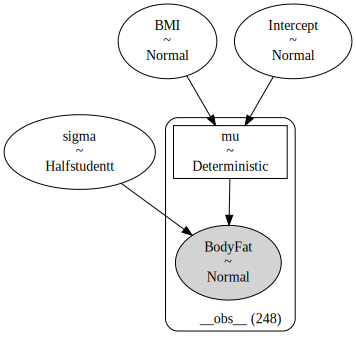

In [19]:
linear_model.graph() # you might get warnings here

Check MCMC diagnostics:

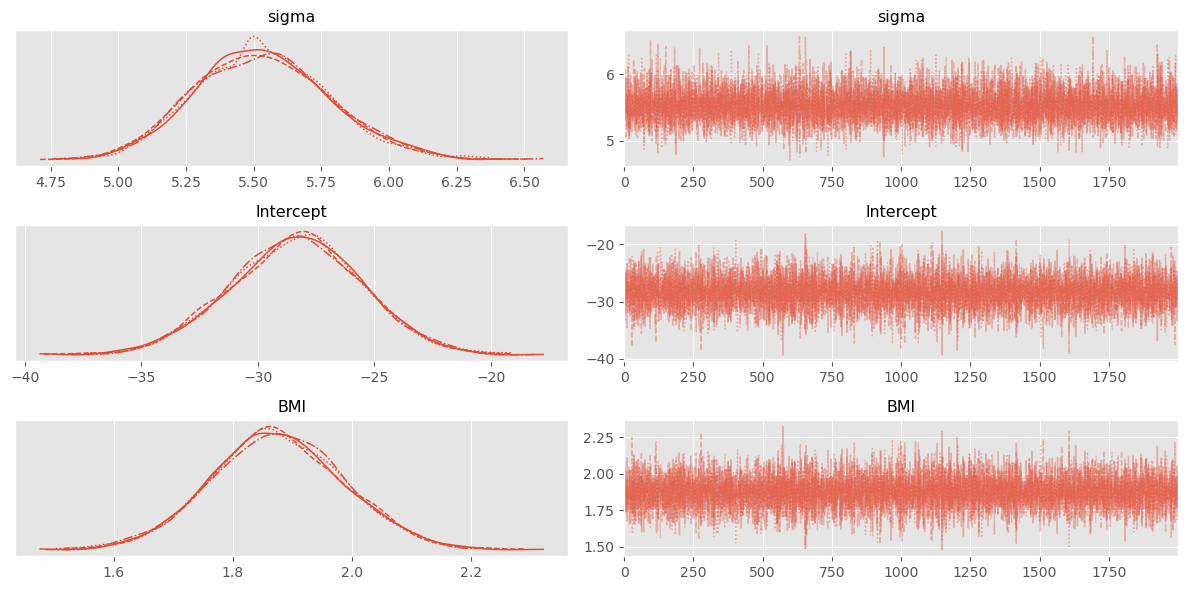

In [20]:
pm.plot_trace( linear_model_fit )
plt.tight_layout()

Posterior distributions:

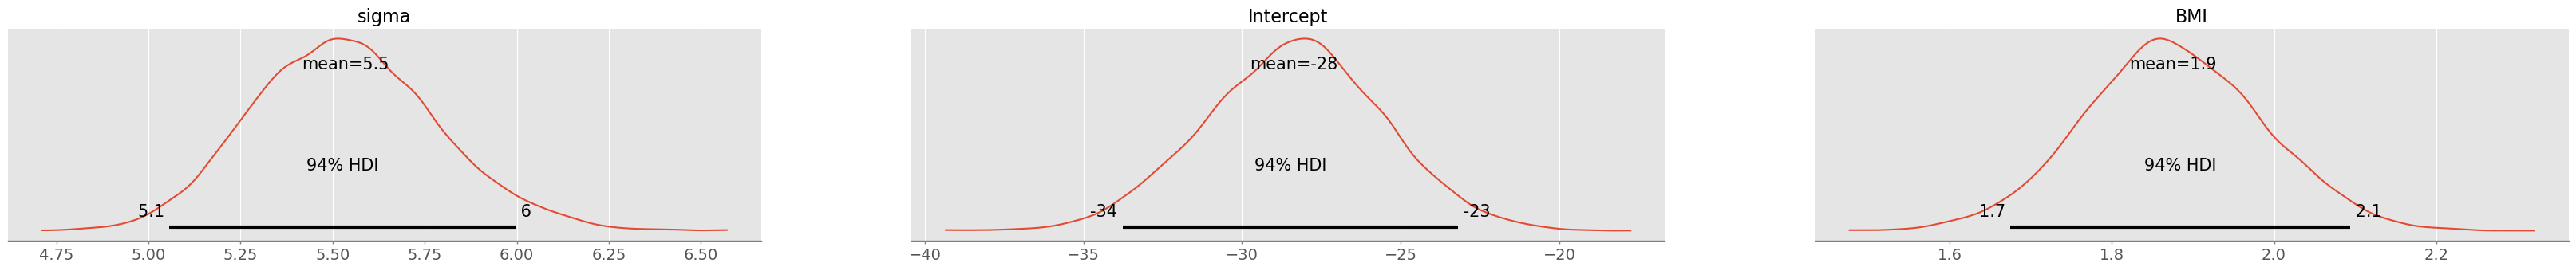

In [21]:
pm.plot_posterior( linear_model_fit );

In [22]:
pm.summary( linear_model_fit )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,5.534,0.251,5.057,5.997,0.002,0.003,12303.0,6175.0,1.0
Intercept,-28.365,2.831,-33.761,-23.193,0.025,0.033,13123.0,6182.0,1.0
BMI,1.875,0.111,1.675,2.094,0.001,0.001,13151.0,6212.0,1.0


Choosing your own priors:

In [23]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=data_simple.BodyFat.mean(), sigma=10),
    "BMI": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1/10)
}
linear_model2 = bmb.Model("BodyFat ~ 1 + BMI", data_simple, priors=priors, family="gaussian")
linear_model_fit2 = linear_model2.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, BMI]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


### Visualizing lines with `bmb.interpret.plot_predictions()`:

Epistemic uncertainty (uncertainty in lines):

Default computed for conditional variable: BMI


(<Figure size 1200x300 with 1 Axes>,
 array([<Axes: xlabel='BMI', ylabel='BodyFat'>], dtype=object))

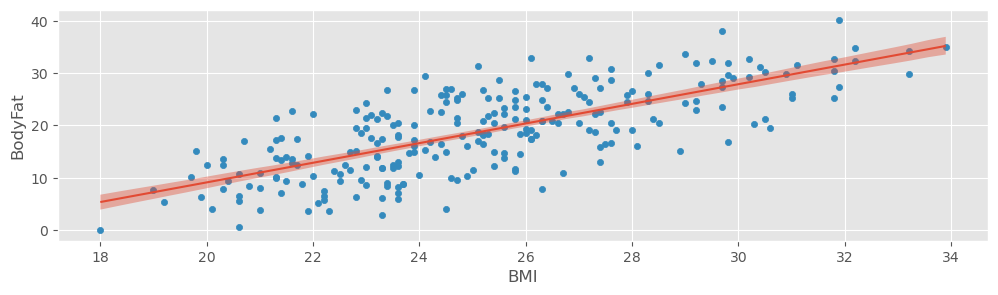

In [24]:
data_simple.plot.scatter( x="BMI", y="BodyFat" )
bmb.interpret.plot_predictions( linear_model, linear_model_fit, "BMI", prob=0.9, ax=plt.gca() )

Predictive uncertainty (uncertainty in predictions): Set `pps=True`

Default computed for conditional variable: BMI


(<Figure size 1200x300 with 1 Axes>,
 array([<Axes: xlabel='BMI', ylabel='BodyFat'>], dtype=object))

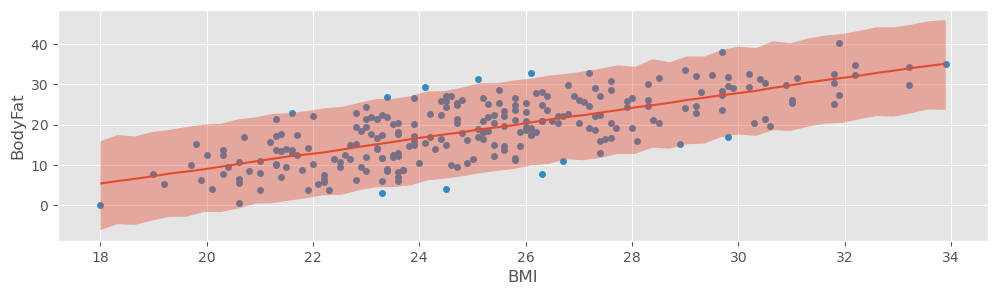

In [25]:
data_simple.plot.scatter( x="BMI", y="BodyFat" )
bmb.interpret.plot_predictions( linear_model, linear_model_fit, "BMI", pps=True, prob=0.95, ax=plt.gca() )

### Making Predictions

In [26]:
pred = linear_model.predict( linear_model_fit, kind="response", data=pd.DataFrame({'BMI': [27]}), inplace=False )
pm.summary( pred.posterior_predictive, hdi_prob=0.9 )

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
BodyFat[0],22.191,5.528,12.964,31.035,0.063,0.044,7625.0,7828.0,1.0


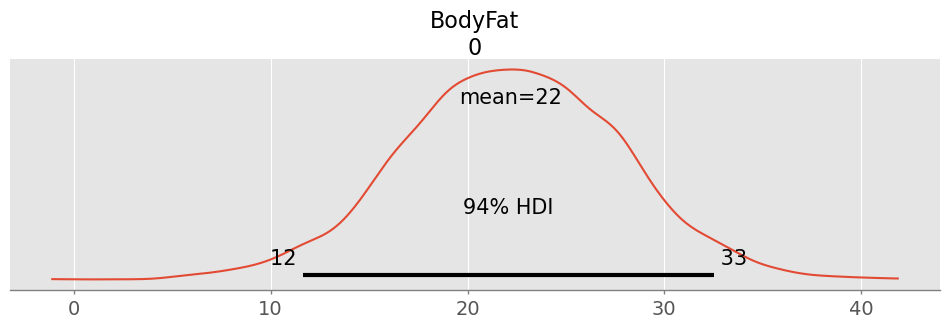

In [27]:
pm.plot_posterior( pred.posterior_predictive );

Aleatoric vs epistemic uncertainty in this particular prediction:

In [28]:
pred = linear_model.predict( linear_model_fit, kind="response", data=pd.DataFrame({'BMI': [27]}), inplace=False )
var_e = pred.posterior.mu.var().values
var_p = pred.posterior_predictive.BodyFat.var().values
var_a = var_p - var_e
np.sqrt( var_a ), np.sqrt( var_e ), np.sqrt( var_p )

(np.float64(5.639130176918879),
 np.float64(0.40299353370951146),
 np.float64(5.653511558354579))

In [29]:
var_a/var_p, var_e/var_p

(np.float64(0.9949188784225704), np.float64(0.005081121577429494))

Aleatoric uncertainty dominates by large!

### Measuring Performance

Create predictions (unfortunately this seems to be the quickest way):

In [30]:
linear_model.predict(linear_model_fit, kind="response")
ypred = az.extract( linear_model_fit.posterior_predictive ).BodyFat.values.T
ytrue = data_simple.BodyFat.values

RMSE:

In [31]:
np.sqrt( np.mean( (ypred - ytrue)**2 ) )

np.float64(7.816260565357623)

MAE:

In [32]:
np.mean( np.abs( ypred - ytrue ) )

np.float64(6.270408436192932)

Bayesian $R^2$:

In [33]:
pm.r2_score( ytrue, ypred )

r2        0.517301
r2_std    0.027082
dtype: float64

or with formula from lecture notes for $R_s^2$ per sample (over 8000 MCMC samples):

In [34]:
rsquared = np.var( ypred, axis=1 ) / (np.var( ypred, axis=1)  + np.var( ypred-ytrue, axis=1 ))
print("r2: {:.6f}, r2_std: {:.6f}".format( np.mean( rsquared ), np.std( rsquared ) ) )

r2: 0.517301, r2_std: 0.027082


90% credible interval for $R^2$:

In [35]:
pm.hdi( rsquared, hdi_prob=0.9 )

array([0.47018026, 0.55870855])

Distribution for $R^2$ values:

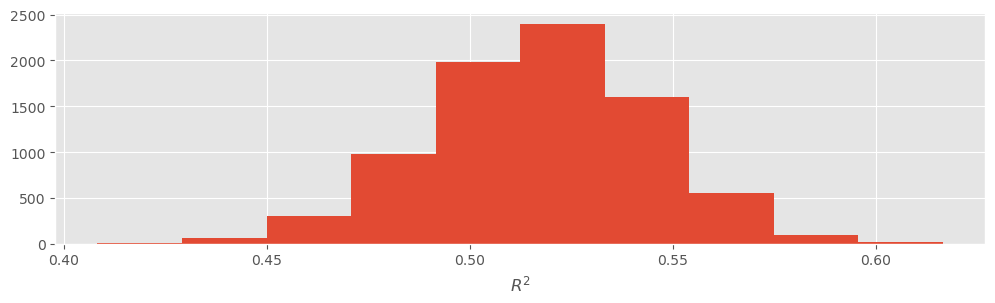

In [36]:
plt.hist( rsquared )
plt.xlabel("$R^2$");

## Posterior Predictive Test

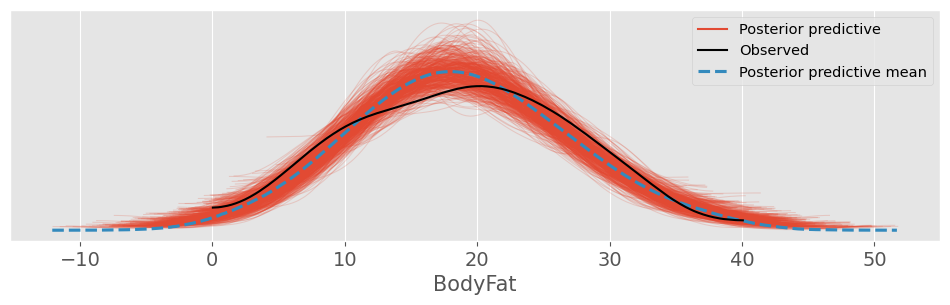

In [37]:
linear_model.predict(linear_model_fit, kind="response")
pm.plot_ppc(linear_model_fit, num_pp_samples=500);